# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from collections import defaultdict
from tqdm import tqdm

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

# Data

In [2]:
df = pd.read_csv("../files/data/Corner_Crack_CS1/Small_Cracks_CS_bt0d75.csv", index_col=False)
df = df[df['a/t'] < 0.75]
df

,W/R,a/c,a/t,r/t,b/t,phi,K-T,K-B,K-P
0,1.6,0.1,0.01,6.000,0.75,0.00006,0.4187,0.2432,0.2665
1,1.6,0.1,0.01,6.000,0.75,0.00012,0.4312,0.2504,0.2744
2,1.6,0.1,0.01,6.000,0.75,0.00018,0.4398,0.2555,0.2799
3,1.6,0.1,0.01,6.000,0.75,0.00024,0.4448,0.2584,0.2831
4,1.6,0.1,0.01,6.000,0.75,0.00030,0.4475,0.2599,0.2849
...,...,...,...,...,...,...,...,...,...
20512117,100.0,10.0,0.10,1.333,0.75,1.57056,0.5303,0.2946,0.1341
20512118,100.0,10.0,0.10,1.333,0.75,1.57062,0.5243,0.2913,0.1326
20512119,100.0,10.0,0.10,1.333,0.75,1.57068,0.5153,0.2863,0.1303
20512120,100.0,10.0,0.10,1.333,0.75,1.57074,0.5026,0.2792,0.1271


In [3]:
# Get unique combinations of the first four columns
CC_combinations = df.iloc[:, :5].drop_duplicates().to_numpy()

print(len(CC_combinations))

114449


In [4]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
print("Different b/t values: ", np.unique(CC_combinations[:,4], axis=0))

Different W/r values:  [  1.6   1.8   2.    2.2   2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2
   5.8   6.4   7.    8.    9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
Different r/t values:  [0.1    0.111  0.125  0.1428 0.25   0.333  0.4    0.4444 0.5    0.5714
 0.667  0.75   0.8    1.     1.25   1.333  1.5    1.75   2.     2.25
 3.     4.     5.     6.     7.     8.     9.    ]
Different b/t values:  [0.75]


In [5]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:5])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

In [6]:
d_final = np.zeros((len(CC_combinations)*128, 10))

num_removed = 0
for i, combination in tqdm(enumerate(CC_combinations)):
    data = np.zeros((128, 10))
    comb_tuple = tuple(combination)
    data[:,0] = i
    data[:,1:6] = comb_tuple

    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, -4]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    CC_phi_regular_128 = np.linspace(phi_min, phi_max, 132)
    data[:,-4] = CC_phi_regular_128[2:-2]


    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,-4]
    if len(phi_vals) > 16:
        phi_idxes = np.argsort(phi_vals)
        monotonic_phi_idxes = [phi_idxes[0]]
        prev_phi = phi_vals[phi_idxes[0]]
        for index in phi_idxes[1:]:
            now_phi = phi_vals[index]
            if now_phi > prev_phi:
                monotonic_phi_idxes.append(index)
                prev_phi = phi_vals[index]

        # Tension
        K_vals = d[filtered_indices][:,-3]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-3] = interp_func(CC_phi_regular_128)[2:-2]

        # Bending
        K_vals = d[filtered_indices][:,-2]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-2] = interp_func(CC_phi_regular_128)[2:-2]

        # Bearing
        K_vals = d[filtered_indices][:,-1]
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        data[:,-1] = interp_func(CC_phi_regular_128)[2:-2]

        if np.isnan(data).any():
            num_removed += 1
            continue

        else:
            d_final[i*128:i*128+128] = data

    else:
        num_removed += 1
        continue


d_final = d_final[~np.all(d_final == 0, axis=1)]

output_df = pd.DataFrame(d_final, columns=["c_index", "W/R", "a/c", "a/t", "r/t", "b/t", "phi", "K-T", "K-B", "K-P"])

# Save the cleaned and processed DataFrame to a new CSV file
output_df.to_csv("../files/data/FINAL_CSV/CORNER_CRACK_CS1_QUARTER_ELLIPSE.csv", index=False)

print("Cracks removed: ", num_removed)

114449it [01:24, 1357.39it/s]


Cracks removed:  7


# Data Viz

In [3]:
df = pd.read_csv("../files/data/FINAL_CSV/SINGLE/CORNER_CRACK_CS1_QUARTER_ELLIPSE.csv")
df

,c_index,W/R,a/c,a/t,r/t,b/t,phi,K-T,K-B,K-P
0,0.0,1.6,0.1,0.01,6.000,0.75,0.057972,0.478551,0.277793,0.304652
1,0.0,1.6,0.1,0.01,6.000,0.75,0.069428,0.487040,0.282748,0.310034
2,0.0,1.6,0.1,0.01,6.000,0.75,0.080884,0.496964,0.288399,0.316331
3,0.0,1.6,0.1,0.01,6.000,0.75,0.092340,0.508210,0.294862,0.323450
4,0.0,1.6,0.1,0.01,6.000,0.75,0.103796,0.520393,0.301939,0.331222
...,...,...,...,...,...,...,...,...,...,...
14648571,114448.0,100.0,10.0,0.10,1.333,0.75,1.467062,0.617348,0.343517,0.156129
14648572,114448.0,100.0,10.0,0.10,1.333,0.75,1.478518,0.603136,0.335496,0.152533
14648573,114448.0,100.0,10.0,0.10,1.333,0.75,1.489974,0.590064,0.328146,0.149198
14648574,114448.0,100.0,10.0,0.10,1.333,0.75,1.501431,0.578330,0.321592,0.146208


In [4]:
crack_idx = df['c_index'].unique()

crack_idx_train, crack_idx_test = train_test_split(crack_idx, test_size=0.25, random_state=10)

# Create a boolean mask for rows where the value in '"c_index"' is in list1
train_list_mask = df["c_index"].isin(crack_idx_train)

# Create a boolean mask for rows where the value in '"c_index"' is in list2
test_list_mask = df["c_index"].isin(crack_idx_test)

# Use the masks to create the two new DataFrames
df_train = df[train_list_mask].copy() # Using .copy() to avoid SettingWithCopyWarning
df_test = df[test_list_mask].copy() # Using .copy() to avoid SettingWithCopyWarning


assert (np.sort(crack_idx_train) == np.sort(df_train['c_index'].unique())).all()
assert (np.sort(crack_idx_test) == np.sort(df_test['c_index'].unique())).all()

print(len(crack_idx_train))
print(len(crack_idx_test))

85831
28611


In [5]:
# Save the cleaned and processed DataFrame to a new CSV file
df_train.to_csv("../files/data/FINAL_CSV/SINGLE/TRAIN/CORNER_CRACK_CS1_QUARTER_ELLIPSE_TRAIN.csv", index=False)
df_test.to_csv("../files/data/FINAL_CSV/SINGLE/TEST/CORNER_CRACK_CS1_QUARTER_ELLIPSE_TEST.csv", index=False)

Total cracks:  114442


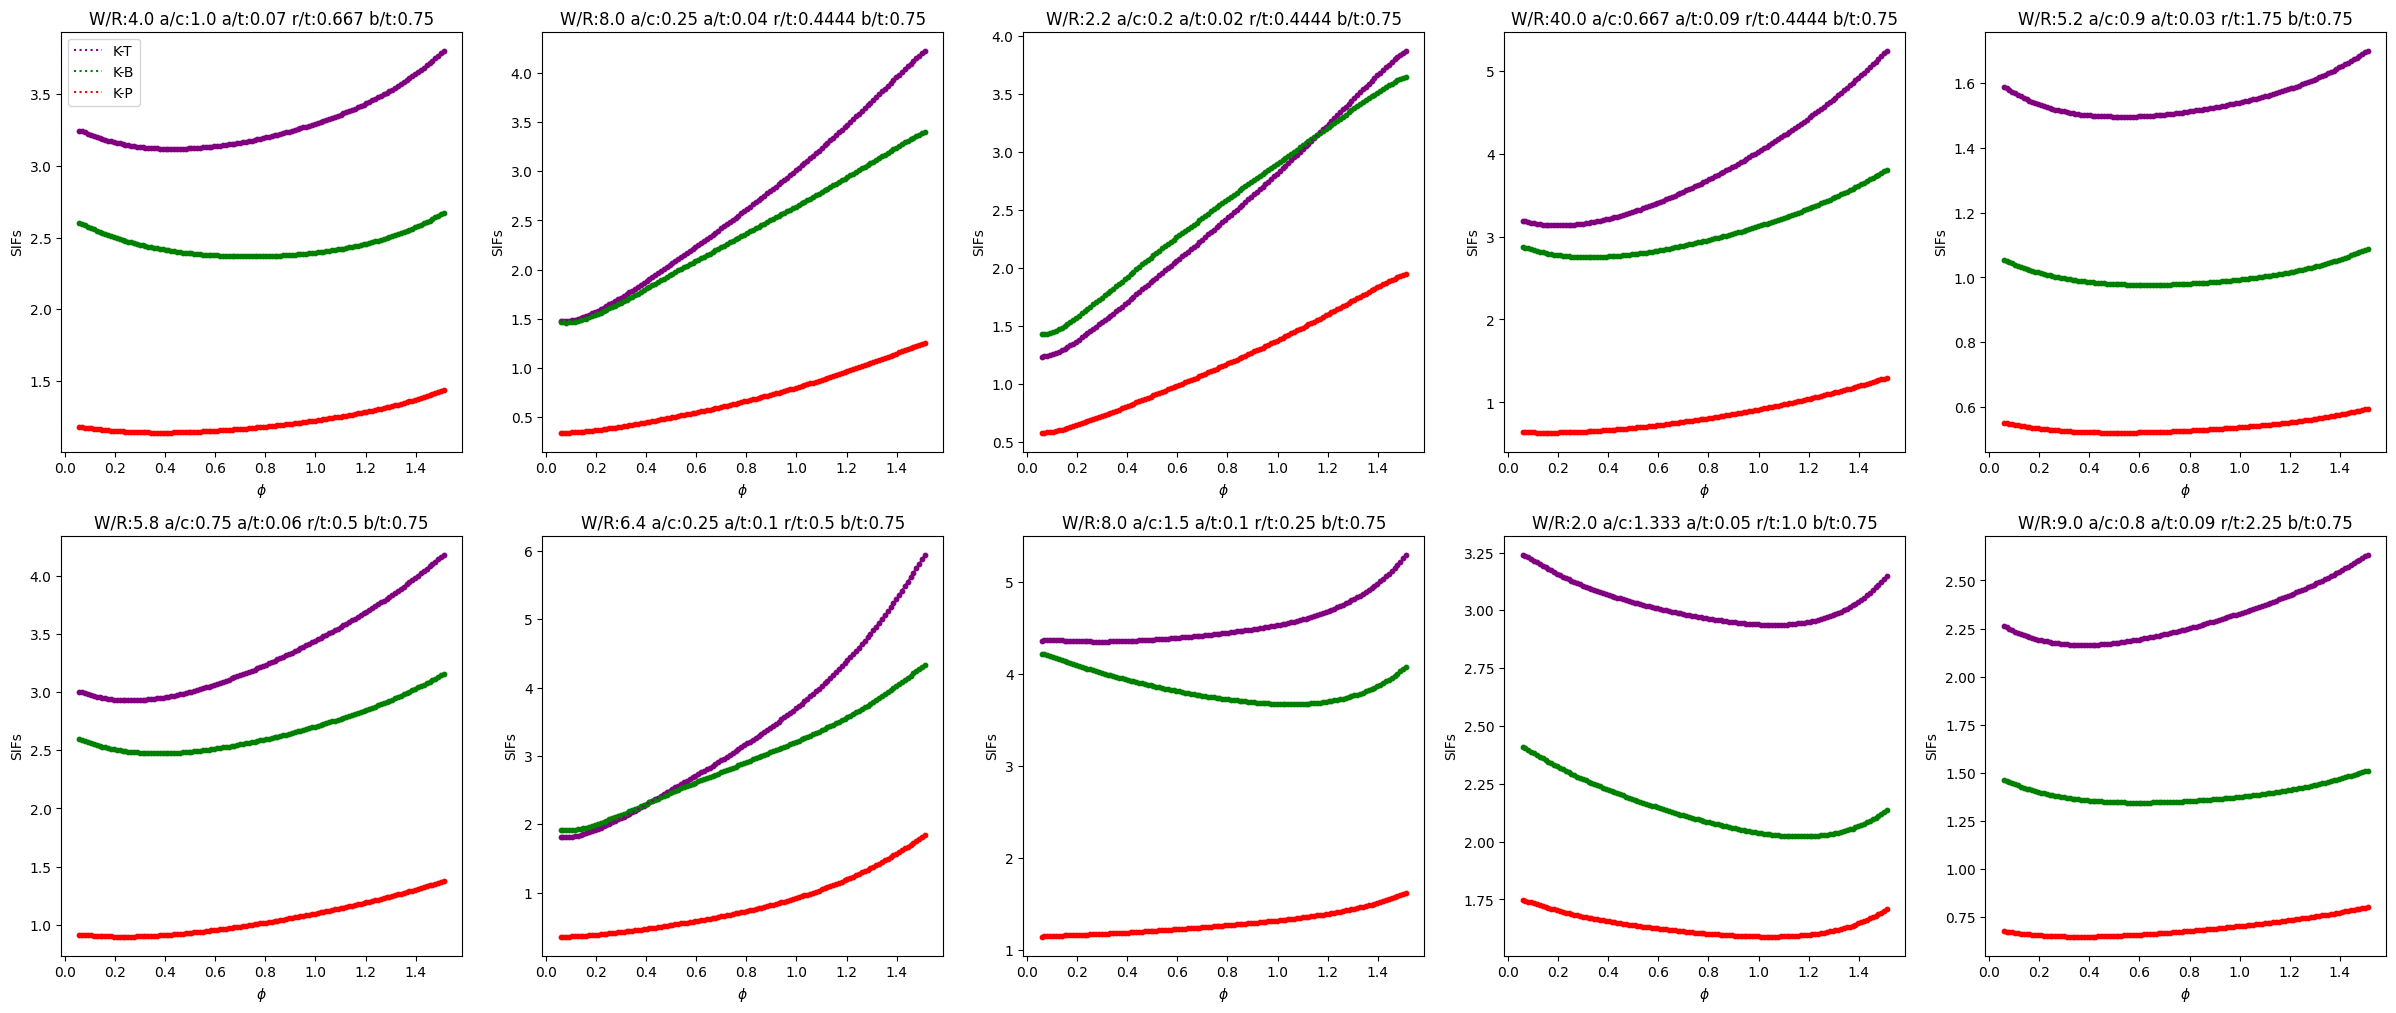

In [8]:
d = df.to_numpy()

num_crack = np.unique(d[:,0])

print("Total cracks: ", len(num_crack))

np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a_c = np.unique(data[:,2])
        a_t = np.unique(data[:,3])
        r_t = np.unique(data[:,4])
        b_t = np.unique(data[:,5])

        assert len(W_R) == 1
        assert len(a_c) == 1
        assert len(a_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-4], data[:,-3], color='purple', s=10)
        axs[i,j].plot(data[:,-4], data[:,-3], label="K-T", color='purple', linestyle=":")

        axs[i,j].scatter(data[:,-4], data[:,-2], color='green', s=10)
        axs[i,j].plot(data[:,-4], data[:,-2], label="K-B", color='green', linestyle=":")

        axs[i,j].scatter(data[:,-4], data[:,-1], color='red', s=10)
        axs[i,j].plot(data[:,-4], data[:,-1], label="K-P", color='red', linestyle=":")

        axs[i,j].set_title("W/R:{} a/c:{} a/t:{} r/t:{} b/t:{}".format(W_R[0], a_c[0], a_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()